Loading data...
Successfully loaded 6236 verses.
Generating sentiment labels...
Label Distribution:
 label
1    3224
2    2075
0     937
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.907800,0.923169,0.589744,0.531789,0.491719,0.589744
200,0.621100,0.565283,0.791667,0.795966,0.804858,0.791667
300,0.421900,0.423223,0.854968,0.854948,0.857669,0.854968
400,0.308300,0.381363,0.885417,0.884223,0.885280,0.885417
500,0.298100,0.341607,0.882212,0.881468,0.886821,0.882212
600,0.247700,0.313822,0.901442,0.900871,0.902797,0.901442
700,0.153300,0.309463,0.911859,0.912317,0.913469,0.911859
800,0.129000,0.316431,0.907051,0.906171,0.907139,0.907051
900,0.124800,0.296166,0.910256,0.909873,0.910401,0.910256


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


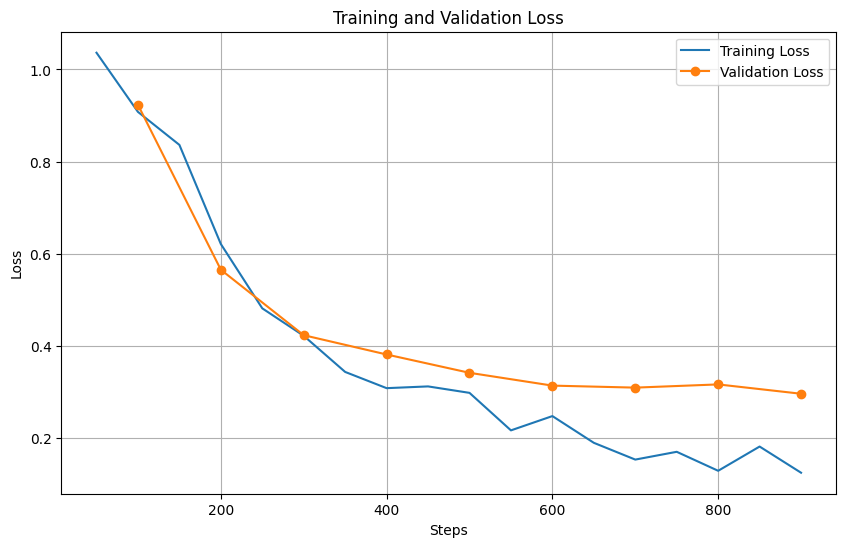

Final Test Loss: 0.3416072726249695
Final Test Accuracy: 0.8822115384615384


In [2]:
# ==========================================
# Quran Sentiment Analysis with DistilBERT
# ==========================================

# 1. INSTALL DEPENDENCIES
!pip install -q transformers datasets torch textblob pandas scikit-learn accelerate matplotlib

import os
# DISABLE WANDB API KEY PROMPT
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import torch
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# 2. LOAD DATA
print("Loading data...")
try:
    df = pd.read_csv('quran_sahih.csv')
    print(f"Successfully loaded {len(df)} verses.")
except FileNotFoundError:
    print("ERROR: 'quran_sahih.csv' not found.")
    print("Please upload your CSV file to the Colab files section.")
    raise

# 3. GENERATE LABELS (Silver Labeling)
def get_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0.05:
        return 2 # Positive
    elif polarity < -0.05:
        return 0 # Negative
    else:
        return 1 # Neutral

print("Generating sentiment labels...")
df['label'] = df['text'].apply(get_sentiment)
print("Label Distribution:\n", df['label'].value_counts())

# 4. PREPROCESSING
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class QuranDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = QuranDataset(train_texts, train_labels, tokenizer)
test_dataset = QuranDataset(test_texts, test_labels, tokenizer)

# 5. MODEL SETUP
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Training Configurations
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=500,
    load_best_model_at_end=True,
    optim="adamw_torch",       # Ensures compatibility with TPUs/GPUs
    report_to=None             # Explicitly turns off third-party logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 6. TRAIN
print("Starting training...")
trainer.train()

# 7. VISUALIZATION
history = trainer.state.log_history
train_loss = []
eval_loss = []
steps = []
eval_steps = []

for entry in history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 8. FINAL RESULTS
results = trainer.evaluate()
print("Final Test Loss:", results['eval_loss'])
print("Final Test Accuracy:", results['eval_accuracy'])

In [3]:
# ==========================================
# SAVE THE MODEL
# ==========================================
save_directory = "./quran_sentiment_model"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./quran_sentiment_model


In [4]:
# ==========================================
# LOAD MODEL & TEST
# ==========================================
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import textwrap

# 1. Load the saved model and tokenizer
model_path = "./quran_sentiment_model"
print(f"Loading model from {model_path}...")

loaded_model = DistilBertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

print("Model loaded successfully!")
print("-" * 40)

# 2. Define Prediction Function
def predict_sentiment(text):
    # Prepare input
    inputs = loaded_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = loaded_model(**inputs)

    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs).item()

    # Map to labels
    labels = {0: "Negative 🔴", 1: "Neutral ⚪", 2: "Positive 🟢"}
    confidence = probs[0][predicted_class].item()

    return labels[predicted_class], confidence

# 3. Interactive Loop
while True:
    user_input = input("\nEnter an Ayah (or type 'exit' to stop): ")
    if user_input.lower() == 'exit':
        print("Exiting...")
        break

    if not user_input.strip():
        continue

    sentiment, score = predict_sentiment(user_input)

    print(f"\n📝 Text: {textwrap.shorten(user_input, width=60)}")
    print(f"📊 Sentiment: {sentiment}")
    print(f"📈 Confidence: {score:.4f}")
    print("-" * 40)

Loading model from ./quran_sentiment_model...
Model loaded successfully!
----------------------------------------

Enter an Ayah (or type 'exit' to stop): Their example is that of one who kindled a fire, but when it illuminated what was around him, Allah took away their light and left them in darkness [so] they could not see

📝 Text: Their example is that of one who kindled a fire, but [...]
📊 Sentiment: Positive 🟢
📈 Confidence: 0.9499
----------------------------------------

Enter an Ayah (or type 'exit' to stop): And do not say about those who are killed in the way of Allah, ""They are dead."" Rather, they are alive, but you perceive [it] not.

📝 Text: And do not say about those who are killed in the way [...]
📊 Sentiment: Negative 🔴
📈 Confidence: 0.4195
----------------------------------------

Enter an Ayah (or type 'exit' to stop): exit
Exiting...
